<a href="https://colab.research.google.com/github/WAT-ai/stock-forecasting-trading/blob/master/cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
def get_df (ticker_str):
  ticker = yf.Ticker(ticker_str)
  df = ticker.history(period = '10y')

  return df

In [4]:
df = get_df('YUM')

In [5]:
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.to_pydatetime()
df.index = df.pop('Date')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-02-03 00:00:00-05:00,40.239190,40.657352,39.331180,39.522339,9392310,0.0,0.0
2014-02-04 00:00:00-05:00,42.766078,43.357477,42.144806,43.046844,19678755,0.0,0.0
2014-02-05 00:00:00-05:00,42.861655,42.861655,41.720670,42.138832,7912008,0.0,0.0
2014-02-06 00:00:00-05:00,42.228441,42.927370,42.144808,42.515182,4736911,0.0,0.0
2014-02-07 00:00:00-05:00,42.766076,43.273843,42.682444,42.849709,3965046,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-29 00:00:00-05:00,129.100006,130.550003,128.289993,130.550003,1482100,0.0,0.0
2024-01-30 00:00:00-05:00,130.360001,131.220001,129.580002,130.619995,1421500,0.0,0.0
2024-01-31 00:00:00-05:00,131.449997,131.979996,129.259995,129.490005,2154200,0.0,0.0


In [6]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year, month, day)

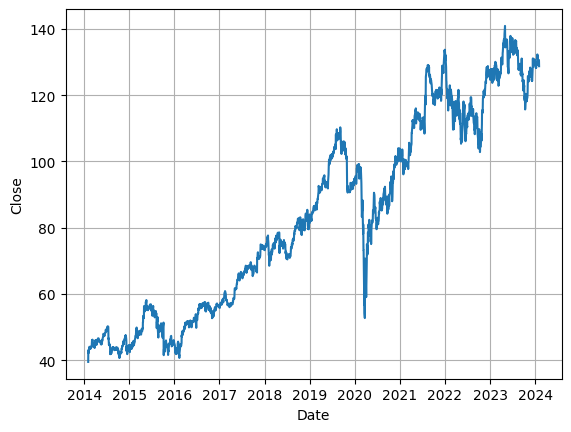

In [7]:
plt.plot(df.index, df["Close"])
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid()
plt.show()

In [8]:
def window_data(data, n):
    windowed_data = pd.DataFrame()
    for i in range(n, 0, -1):
        windowed_data[f'Target-{i}'] = data['Close'].shift(i)
    windowed_data['Target'] = data['Close']
    return windowed_data.dropna()

windowed_df = window_data(df, n=7) # tunable
windowed_df=windowed_df.reset_index()
windowed_df

,Date,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2014-02-12 00:00:00-05:00,39.522339,43.046844,42.138832,42.515182,42.849709,43.464996,43.733837,43.913033
1,2014-02-13 00:00:00-05:00,43.046844,42.138832,42.515182,42.849709,43.464996,43.733837,43.913033,44.098221
2,2014-02-14 00:00:00-05:00,42.138832,42.515182,42.849709,43.464996,43.733837,43.913033,44.098221,43.859264
3,2014-02-18 00:00:00-05:00,42.515182,42.849709,43.464996,43.733837,43.913033,44.098221,43.859264,43.751751
4,2014-02-19 00:00:00-05:00,42.849709,43.464996,43.733837,43.913033,44.098221,43.859264,43.751751,43.500851
...,...,...,...,...,...,...,...,...,...
2506,2024-01-29 00:00:00-05:00,130.460007,132.300003,131.059998,131.750000,129.440002,130.220001,129.089996,130.550003
2507,2024-01-30 00:00:00-05:00,132.300003,131.059998,131.750000,129.440002,130.220001,129.089996,130.550003,130.619995
2508,2024-01-31 00:00:00-05:00,131.059998,131.750000,129.440002,130.220001,129.089996,130.550003,130.619995,129.490005
2509,2024-02-01 00:00:00-05:00,131.750000,129.440002,130.220001,129.089996,130.550003,130.619995,129.490005,130.449997


In [9]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  print (df_as_np)

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

[[Timestamp('2014-02-12 00:00:00-0500', tz='America/New_York')
  39.5223388671875 43.046844482421875 ... 43.464996337890625
  43.73383712768555 43.91303253173828]
 [Timestamp('2014-02-13 00:00:00-0500', tz='America/New_York')
  43.046844482421875 42.138832092285156 ... 43.73383712768555
  43.91303253173828 44.09822082519531]
 [Timestamp('2014-02-14 00:00:00-0500', tz='America/New_York')
  42.138832092285156 42.51518249511719 ... 43.91303253173828
  44.09822082519531 43.8592643737793]
 ...
 [Timestamp('2024-01-31 00:00:00-0500', tz='America/New_York')
  131.05999755859375 131.75 ... 130.5500030517578 130.6199951171875
  129.49000549316406]
 [Timestamp('2024-02-01 00:00:00-0500', tz='America/New_York') 131.75
  129.44000244140625 ... 130.6199951171875 129.49000549316406
  130.4499969482422]
 [Timestamp('2024-02-02 00:00:00-0500', tz='America/New_York')
  129.44000244140625 130.22000122070312 ... 129.49000549316406
  130.4499969482422 128.75]]


((2511,), (2511, 7, 1), (2511,))

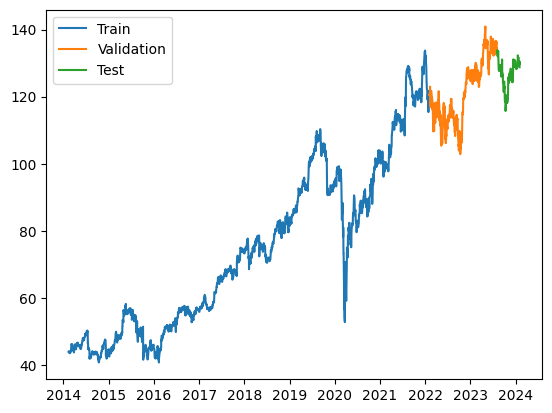

In [10]:
q_80 = int(len(dates) * .8)
q_95 = int(len(dates) * .95)
seven_days = q_95 + 7

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_95], X[q_80:q_95], y[q_80:q_95]
dates_test, X_test, y_test = dates[q_95:], X[q_95:], y[q_95:]
dates_rec = dates[q_95:seven_days]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((7, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(7)])



model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
63/63 [==============================] - 4s 20ms/step - loss: 5844.0767 - mean_absolute_error: 72.3445 - val_loss: 13336.4482 - val_mean_absolute_error: 115.0805
Epoch 2/100
63/63 [==============================] - 1s 8ms/step - loss: 2523.6106 - mean_absolute_error: 41.8405 - val_loss: 2537.3003 - val_mean_absolute_error: 48.4737
Epoch 3/100
63/63 [==============================] - 1s 9ms/step - loss: 585.1034 - mean_absolute_error: 20.5197 - val_loss: 2065.3164 - val_mean_absolute_error: 44.5362
Epoch 4/100
63/63 [==============================] - 1s 14ms/step - loss: 179.2315 - mean_absolute_error: 9.4449 - val_loss: 342.9975 - val_mean_absolute_error: 16.5433
Epoch 5/100
63/63 [==============================] - 1s 12ms/step - loss: 13.2388 - mean_absolute_error: 1.8518 - val_loss: 82.1551 - val_mean_absolute_error: 6.8907
Epoch 6/100
63/63 [==============================] - 1s 14ms/step - loss: 3.7608 - mean_absolute_error: 1.0933 - val_loss: 40.7879 - val_mean_absolute

63/63 [==============================] - 0s 3ms/step


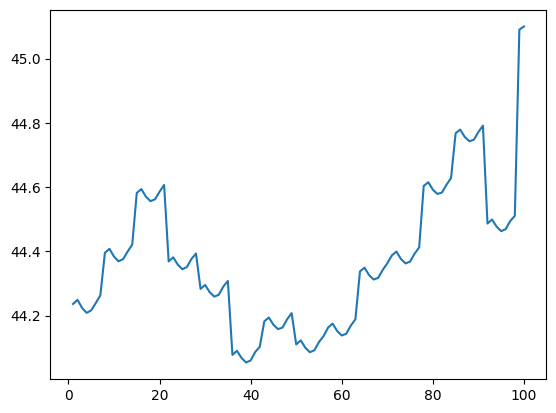

In [31]:
train_predictions = model.predict(X_train).flatten()

x = list(range(1, 101))


plt.plot(x, train_predictions[0:100])

# train_predictions[13000:13400]
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.legend(['Training Predictions', 'Training Observations'])

In [13]:
val_predictions = model.predict(X_val).flatten()

# plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
# plt.legend(['Validation Predictions', 'Validation Observations'])

12/12 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 6ms/step


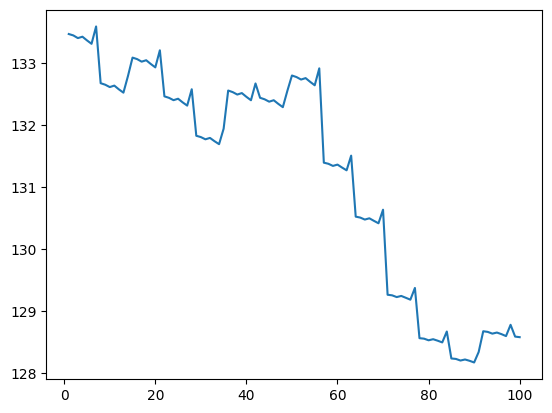

In [30]:
test_predictions = model.predict(X_test).flatten()
x = list(range(1, 101))


plt.plot(x, test_predictions[0:100])
# plt.plot(x, y_test[0:7])



# plt.plot(dates_test, test_predictions)
# plt.plot(dates_test, y_test)
# plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
# recursive_dates = np.concatenate([dates_val, dates_test])
recursive_dates = dates_test
last_window = deepcopy(X_val[-1])

for target_date in dates_rec:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window = np.concatenate([last_window[1:], [next_prediction]])

In [ ]:
# plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)
# plt.plot(dates_test, y_test)
plt.plot(dates_rec, recursive_predictions)
plt.legend([

            'Validation Observations',

            'Recursive Predictions'])

In [ ]:
forecast = recursive_predictions[6]
actual = y_test[6]
forecast, actual

In [ ]:
def mean_absolute_error(actual, forecast):
    return np.mean(np.abs(actual - forecast))

# Mean Squared Error
def mean_squared_error(actual, forecast):
    return np.mean((actual - forecast)**2)

# Root Mean Squared Error
def root_mean_squared_error(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Symmetric Mean Absolute Percentage Error
def symmetric_mape(actual, forecast):
    return np.mean(2.0 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))) * 100

# Cumulative Forecast Error
def cumulative_forecast_error(actual, forecast):
    return np.sum(actual - forecast)

def mean_absolute_percentage_error(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def symmetric_mape(actual, forecast):
    return np.mean(2.0 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))) * 100



# Calculating metrics
mae = mean_absolute_error(actual, forecast)
mse = mean_squared_error(actual, forecast)
rmse = root_mean_squared_error(actual, forecast)
mape = mean_absolute_percentage_error(actual, forecast)
smape = symmetric_mape(actual, forecast)
cfe = cumulative_forecast_error(actual, forecast)
mape = mean_absolute_percentage_error(actual, forecast)
smape = symmetric_mape(actual, forecast)

In [ ]:
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Symmetric MAPE: {smape}")
print(f"Cumulative Forecast Error: {cfe}")
print(f"MAPE: {mape}%")
print(f"sMAPE: {smape}%")
